In [3]:
# import (same as inference.py)
import os
import sys
sys.path.append("../../../")

import torch
import colossalai
import torch.distributed as dist
from mmengine.runner import set_random_seed

from opensora.datasets import save_sample
from opensora.registry import MODELS, SCHEDULERS, build_module
from opensora.utils.build_model import build_models, build_models_only
from opensora.utils.config_utils import parse_configs
from opensora.utils.misc import to_torch_dtype
from opensora.acceleration.parallel_states import set_sequence_parallel_group
from colossalai.cluster import DistCoordinator

from mmengine.config import Config

# ======================================================
# 1. cfg and init distributed env
# ======================================================
config_path = "../../../configs/opensora/inference/16x512x512.py"
cfg = Config.fromfile(config_path)
cfg.gpu = "0"
cfg.model["from_pretrained"] = "/share/liuenshu/temp_files/checkpoints/video/OpenSora-v1-HQ-16x512x512.pth"

# ======================================================
# 2. runtime variables
# ======================================================
torch.set_grad_enabled(False)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
device = f"cuda:{cfg.gpu}" if torch.cuda.is_available() else "cpu"
dtype = to_torch_dtype(cfg.dtype)

/home/liuenshu/anaconda3/envs/opensora/lib/python3.10/site-packages/colossalai/pipeline/schedule/_utils.py:19: UserWarning:

torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.

/home/liuenshu/anaconda3/envs/opensora/lib/python3.10/site-packages/torch/utils/_pytree.py:254: UserWarning:

<class 'collections.OrderedDict'> is already registered as pytree node. Overwriting the previous registration.

/home/liuenshu/anaconda3/envs/opensora/lib/python3.10/site-packages/colossalai/shardformer/layer/normalization.py:45: UserWarning:

Please install apex from source (https://github.com/NVIDIA/apex) to use the fused layernorm kernel



In [4]:
# get model
model = build_models_only(cfg, device, dtype, enable_sequence_parallelism=False)

Missing keys: ['pos_embed', 'pos_embed_temporal']
Unexpected keys: []


In [5]:
# get weights function
import numpy as np

def get_weights(model, layer_name):
    for name, module in model.named_parameters():

        if name == layer_name:
            weights = module.data
            weights_np = weights.cpu().detach().numpy()
            out_channels, in_channels = weights_np.shape[0:2]
            
            if len(weights_np.shape)==4:
                weights_np = weights_np.mean(axis=(2, 3))
                weights_np = weights_np.reshape(out_channels, in_channels)
            
            return weights_np

In [6]:
# test: print weight name
name_list = []

for name, module in model.named_parameters():
    name_list.append(name)
    
print(name_list)

['x_embedder.proj.weight', 'x_embedder.proj.bias', 't_embedder.mlp.0.weight', 't_embedder.mlp.0.bias', 't_embedder.mlp.2.weight', 't_embedder.mlp.2.bias', 't_block.1.weight', 't_block.1.bias', 'y_embedder.y_proj.fc1.weight', 'y_embedder.y_proj.fc1.bias', 'y_embedder.y_proj.fc2.weight', 'y_embedder.y_proj.fc2.bias', 'blocks.0.scale_shift_table', 'blocks.0.attn.q.weight', 'blocks.0.attn.q.bias', 'blocks.0.attn.k.weight', 'blocks.0.attn.k.bias', 'blocks.0.attn.v.weight', 'blocks.0.attn.v.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.cross_attn.q_linear.weight', 'blocks.0.cross_attn.q_linear.bias', 'blocks.0.cross_attn.kv_linear.weight', 'blocks.0.cross_attn.kv_linear.bias', 'blocks.0.cross_attn.proj.weight', 'blocks.0.cross_attn.proj.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.0.attn_temp.q.weight', 'blocks.0.attn_temp.q.bias', 'blocks.0.attn_temp.k.weight', 'blocks.0.attn_temp.k.bias', '

(2304, 1152)
0.3066
0.0


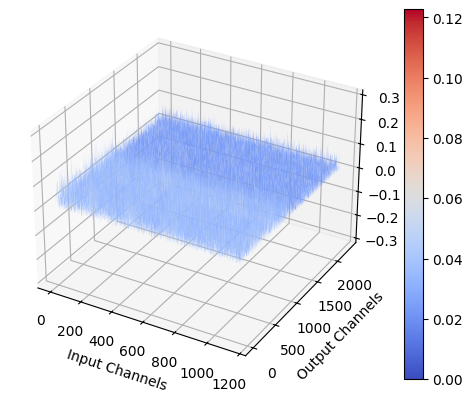

In [5]:
# 3D view. Use matplotlib

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os

weight_id = "blocks.6.cross_attn.kv_linear.weight"
weights_np = get_weights(model, weight_id)
out_channels, in_channels = weights_np.shape
_x = np.arange(in_channels)
_y = np.arange(out_channels)
_X, _Y = np.meshgrid(_x, _y)

# Add new figure and subplot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 3D surface
print(weights_np.shape)
# TODO: only draw a part of samples to avoid 
surf = ax.plot_surface(_X, _Y, weights_np, cmap='coolwarm', vmin=np.min(weights_np), vmax=np.max(weights_np)/2.5)


# 设置轴标签
ax.set_xlabel('Input Channels')
ax.set_ylabel('Output Channels')
ax.set_zlabel('Absolute Weights')

ax.set_zlim([-np.max(np.abs(weights_np)), np.max(np.abs(weights_np))])
print(np.max(np.abs(weights_np)))
print(np.min(np.abs(weights_np)))

# Add color bar
fig.colorbar(surf)

plt.show()

5.33
0.0


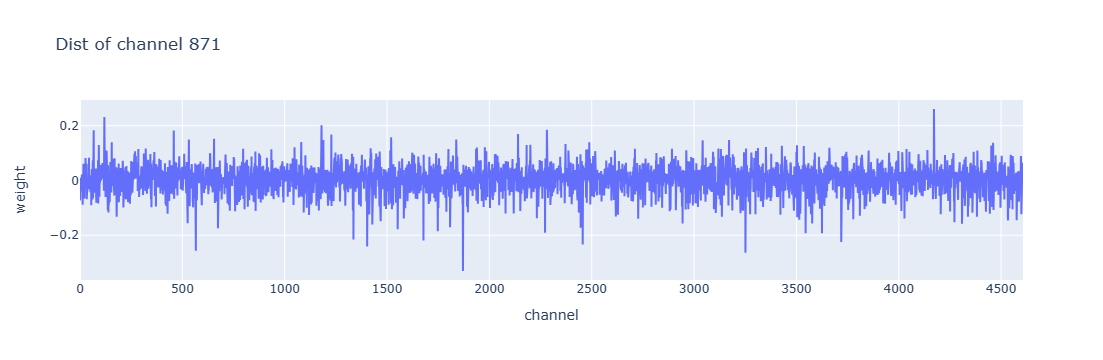

In [13]:
# 3D view. Use plotly. Faile to demonstrate

import plotly.graph_objects as go
import numpy as np
import random
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

weight_id = "blocks.27.mlp.fc2.weight"  
weights_np = get_weights(model, weight_id)
out_channels, in_channels = weights_np.shape

# Assuming you have the meshgrid arrays _X, _Y, and weights_np defined

fig = go.Figure()

colormap_span = 3
channel_subsample = None

if channel_subsample is not None:
    out_channels = channel_subsample
    in_channels = channel_subsample
    weights_np_ = weights_np[:channel_subsample, :channel_subsample]
else:
    weights_np_ = weights_np
    
# set X，Y meshgrid
_x = np.arange(out_channels)
_y = np.arange(in_channels)
_X, _Y = np.meshgrid(_x, _y)

_X = _X.T
_Y = _Y.T

# weights is channel wise quantized so visualizing several channels is ok
# select out channels to visualize
vis_channel_num = 1
# random select
random_indices = random.sample(list(range(out_channels)), k=vis_channel_num)
random_indices = sorted(random_indices)
index = random_indices
# fixed select
index = [871]

vis_X = _X[index]
vis_Y = _Y
vis_weights = weights_np_[random_indices, :]

if vis_channel_num == 1:
    fig = go.Figure(data=go.Scatter(x=vis_Y[0], y=vis_weights[0], mode='lines'))
    fig.update_layout(title=f'Dist of channel {index[0]}', xaxis_title='channel', yaxis_title='weight')
else:
    surf = go.Surface(x=vis_X, y=vis_Y, z=vis_weights, colorscale='viridis', cmin=np.min(weights_np_), \
                      cmax=np.max(weights_np_), opacity=0.5)
    fig.add_trace(surf)
    
    # Set z-limits
    fig.update_layout(scene=dict(zaxis=dict(range=[-np.max(np.abs(weights_np)), np.max(np.abs(weights_np))])),
                      width=800, height=800,  # Set the figure size
                     )
    # Add color bar
    fig.update_layout()

# Print max absolute value of weights_np
print(np.max(np.abs(weights_np_)))
print(np.min(np.abs(weights_np)))

# Show the plot
iplot(fig)

In [37]:
import torch
import numpy as np

def compute_weight_info(weights):
    tensor = weights.reshape(-1)
    numpy_array = tensor.cpu().detach().numpy()

    # calculate the entropy
    counts, _ = np.histogram(numpy_array, bins=3000)
    p = counts / counts.sum()
    p = p+1e-10
    entropy = -np.sum(p * np.log(p))

    # calculate the outlier percent
    q1, q2 = np.percentile(numpy_array, [95, 5])
    iqr = q1 - q2
    threshold = 1.5 * iqr
    outliers = numpy_array[(numpy_array < (q1 - threshold)) | (numpy_array > (q2 + threshold))]
    outlier_count = len(outliers) / len(numpy_array)

    # calculate the variance
    variance = np.var(numpy_array)
    print(f'entropy: {entropy}')
    print(f'outlier_percent: {outlier_count*1e3}x1^(-3)')
    print(f'variance: {variance*1e5}x10^(-5)')
    return entropy, outlier_count, variance

def get_weights_info(model):
    weight_names = []
    entropys = []
    variances = []
    outlier_freqs = []
    for name, module in model.named_parameters():
        print(module.data.shape)
        # print(line, type(line))
        weight_names.append(name)
        print("-"*50)
        print(f"name: {name}")
        entropy, variance, outlier_freq = compute_weight_info(module.data)
        entropys.append(entropy)
        variances.append(variance)
        outlier_freqs.append(outlier_freq)
    return weight_names, entropys, variances, outlier_freqs

In [38]:
weight_names, entropys, variances, outlier_freqs = get_weights_info(model)

torch.Size([1152, 4, 1, 2, 2])
--------------------------------------------------
name: x_embedder.proj.weight
entropy: 5.563295763504524
outlier_percent: 26.529947916666668x1^(-3)
variance: 489.80712890625x10^(-5)
torch.Size([1152])
--------------------------------------------------
name: x_embedder.proj.bias
entropy: 5.799877542253992
outlier_percent: 2.6041666666666665x1^(-3)
variance: 7049.560546875x10^(-5)
torch.Size([1152, 256])
--------------------------------------------------
name: t_embedder.mlp.0.weight
entropy: 4.209681211854977
outlier_percent: 17.645941840277775x1^(-3)
variance: 12.850761413574219x10^(-5)
torch.Size([1152])
--------------------------------------------------
name: t_embedder.mlp.0.bias
entropy: 4.6060570293123195
outlier_percent: 23.4375x1^(-3)
variance: 76.86614990234375x10^(-5)
torch.Size([1152, 1152])
--------------------------------------------------
name: t_embedder.mlp.2.weight
entropy: 2.6673975008528186
outlier_percent: 15.753851996527777x1^(-3)
va

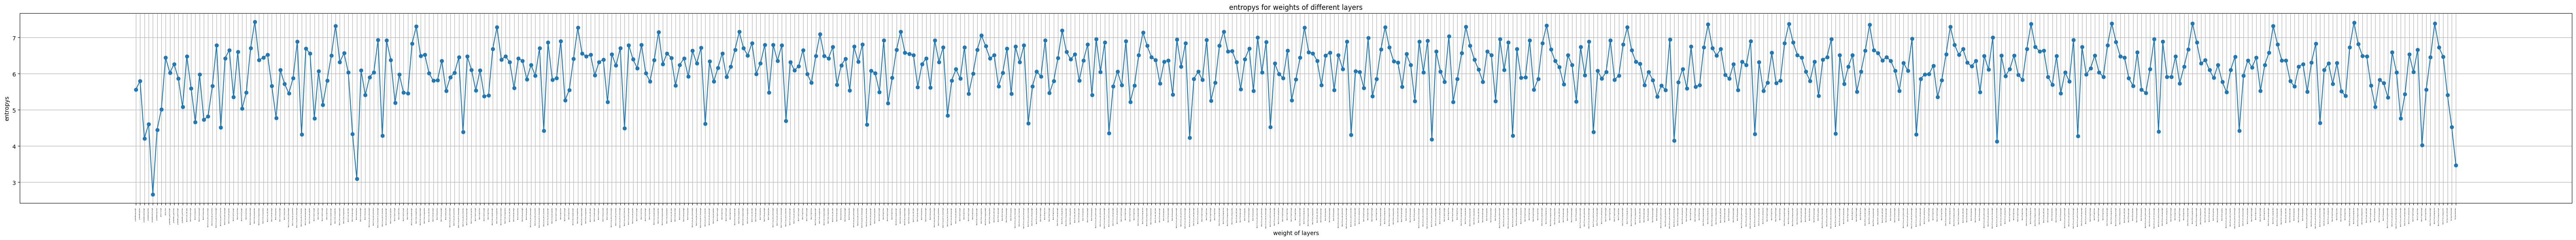

In [11]:
import os

save_path = "/share/liuenshu/temp_files/video_exp/analysis"
plt.figure(figsize=(80, 6))
plt.plot(weight_names, entropys, marker='o')
plt.xlabel('weight of layers')
plt.ylabel('entropys')
plt.title('entropys for weights of different layers')
plt.grid(True)
plt.xticks(rotation=90, fontsize=2)
os.makedirs(save_path, exist_ok=True)
plt.savefig(os.path.join(save_path, "result.pdf"))

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors

import plotly.graph_objects as go
import numpy as np
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

def select_random_indices(input_data, l, select_dim):
    assert select_dim in list(range(5))
    out_channels = input_data.shape[select_dim]
    random_indices = random.sample(list(range(out_channels)), k=l)
    random_indices = sorted(random_indices)
    index = random_indices
    if select_dim == 0:
        part_input_data = input_data[index]
    elif select_dim == 1:
        part_input_data = input_data[:, index]
    elif select_dim == 2:
        part_input_data = input_data[:, :, index]
    elif select_dim == 3:
        part_input_data = input_data[:, :, :, index]
    elif select_dim == 4:
        part_input_data = input_data[:, :, :, :, index]
    else:
        raise NotImplementedError 
    return part_input_data

def plot_activation_3d(input_data, name, color_top, type='plotly'):
    inputs_np = np.abs(input_data.detach().cpu().numpy())

    if len(inputs_np.shape)==4:
        batch_size, in_channels = inputs_np.shape[0:2]
        x_data = batch_size
        y_data = in_channels
        inputs_np = inputs_np.mean(axis=(2, 3))
        inputs_np = inputs_np.reshape(batch_size, in_channels)
        x_label = "Batch Size"
    elif len(inputs_np.shape)==3:
        token_length = inputs_np.shape[1]
        in_channels = inputs_np.shape[2]
        x_data = token_length
        y_data = in_channels
        inputs_np = inputs_np.mean(axis=(0))  # along batch dim
        inputs_np = inputs_np.reshape(token_length, in_channels)
        x_label = "Tokens"
    else:
        batch_size = inputs_np.shape[0]
        in_channels = input_data.shape[1]
        x_data = batch_size
        y_data = in_channels
        inputs_np = inputs_np.reshape(batch_size, in_channels)
        x_label = "Batch Size"
        
    _x = np.arange(x_data)
    _y = np.arange(y_data)
    _X, _Y = np.meshgrid(_x, _y)

    _X = _X.T
    _Y = _Y.T

    if type == 'matplotlib':
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        surf = ax.plot_surface(_X, _Y, inputs_np, cmap='coolwarm', vmin=np.min(inputs_np), vmax=color_top)
    
        ax.set_xlabel(x_label)
        ax.set_ylabel('Input Channels')
        ax.set_zlabel('Absolute Activations')
    
        ax.set_zlim([-np.max(np.abs(inputs_np)), np.max(np.abs(inputs_np))])
        print(np.max(np.abs(inputs_np)))
        fig.colorbar(surf)
        ax.view_init(elev=20, azim=20)
        plt.title('the input data of '+name)
        # plt.savefig(f'./distribution_plot/act/Transformer2d_model/3d_distribution/3d_acts_{name}.png')
        plt.show()
    elif type == 'plotly':
        fig = go.Figure()
        colormap_span = 3
        import ipdb; ipdb.set_trace()
        surf = go.Surface(x=_X, y=_Y, z=inputs_np, colorscale='viridis', cmin=np.min(inputs_np), \
                  cmax=np.max(inputs_np),opacity=0.5)
        fig.add_trace(surf)
        
        # Set z-limits
        # fig.update_layout(scene=dict(zaxis=dict(range=[-np.max(np.abs(inputs_np)), np.max(np.abs(inputs_np))])),
        #                   width=800, height=800,xaxis_title=x_label,yaxis_title='input channels'  # Set the figure size
        #                  )
        fig.update_layout(scene=dict(zaxis=dict()),
                          width=800, height=800,xaxis_title=x_label,yaxis_title='input channels'  # Set the figure size
                         )
        # Add color bar
        fig.update_layout()
        
        # Show the plot
        iplot(fig)


def plot_activation_pdf(input_data, channel_type = None, name=''):
    tensor = input_data.reshape(-1)
    numpy_array = tensor.cpu().numpy()

    label = name

    plt.hist(numpy_array, bins=3000, label=label)  

    plt.title(f'the distribution of the input data of the {name}')
    plt.xlabel('value')
    plt.ylabel('freq')

    plt.legend()
    plt.yscale('log')
    # plt.savefig(f'./distribution_plot/act/Transformer2d_model/pdf_distribution/pdf_acts_{name}.png')
    plt.show()

def plot_activation_box(input_data, split_dim=None, name=''):
    tensor = input_data.cpu()  
    if split_dim is None:
        channels = tensor.numpy().flatten()
    else:
        if split_dim == 0: # activations have up to 3 dimensions.
            channels = [tensor[j].numpy().flatten() for j in range(tensor.shape[split_dim])]
        elif split_dim == 1:
            channels = [tensor[:, j].numpy().flatten() for j in range(tensor.shape[split_dim])]
        elif split_dim == 2:
            channels = [tensor[:, :, j].numpy().flatten() for j in range(tensor.shape[split_dim])]
    
    plt.figure(figsize=(22, 10))
    bplot = plt.boxplot(channels, patch_artist=True, notch=True, vert=1)

    colors = ['pink', 'lightblue', 'lightgreen']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    plt.legend([bplot["boxes"][0]], [name], loc='upper right')

    plt.title(f'box-plot of the input_data of the {name}')
    plt.xlabel("")
    plt.ylabel('range')
    # plt.savefig(f'./distribution_plot/act/Transformer2d_model/box_distribution/box_acts_{name}.png')
    plt.show()

def plot_activation_channel(input_data, split_dim=0, name=''):
    print(input_data.shape)
    input_data = input_data.cpu().detach()
    mean_values = torch.mean(input_data, dim=tuple(i for i in range(input_data.dim()) if i != split_dim))
    xs = np.arange(len(mean_values))

    plt.figure(figsize=(5, 3))
    plt.bar(xs, mean_values)
    plt.xlabel("")
    plt.ylabel('range')
    plt.title(f'the mean of input data at dim {split_dim}')
    # plt.savefig(f'./distribution_plot/act/Transformer2d_model/channel_distribution/channel_acts_{name}.png')
    plt.show()

In [43]:
name = "blocks.6.cross_attn.kv_linear.weight"
weights_np = get_weights(model, name)
weights = torch.from_numpy(weights_np)
print(weights.shape)

torch.Size([2304, 1152])


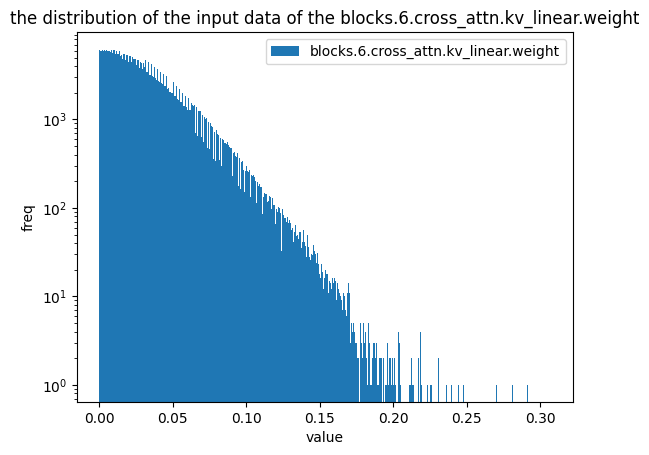

In [44]:
# Global distribution plot
plot_activation_pdf(weights, name=name)

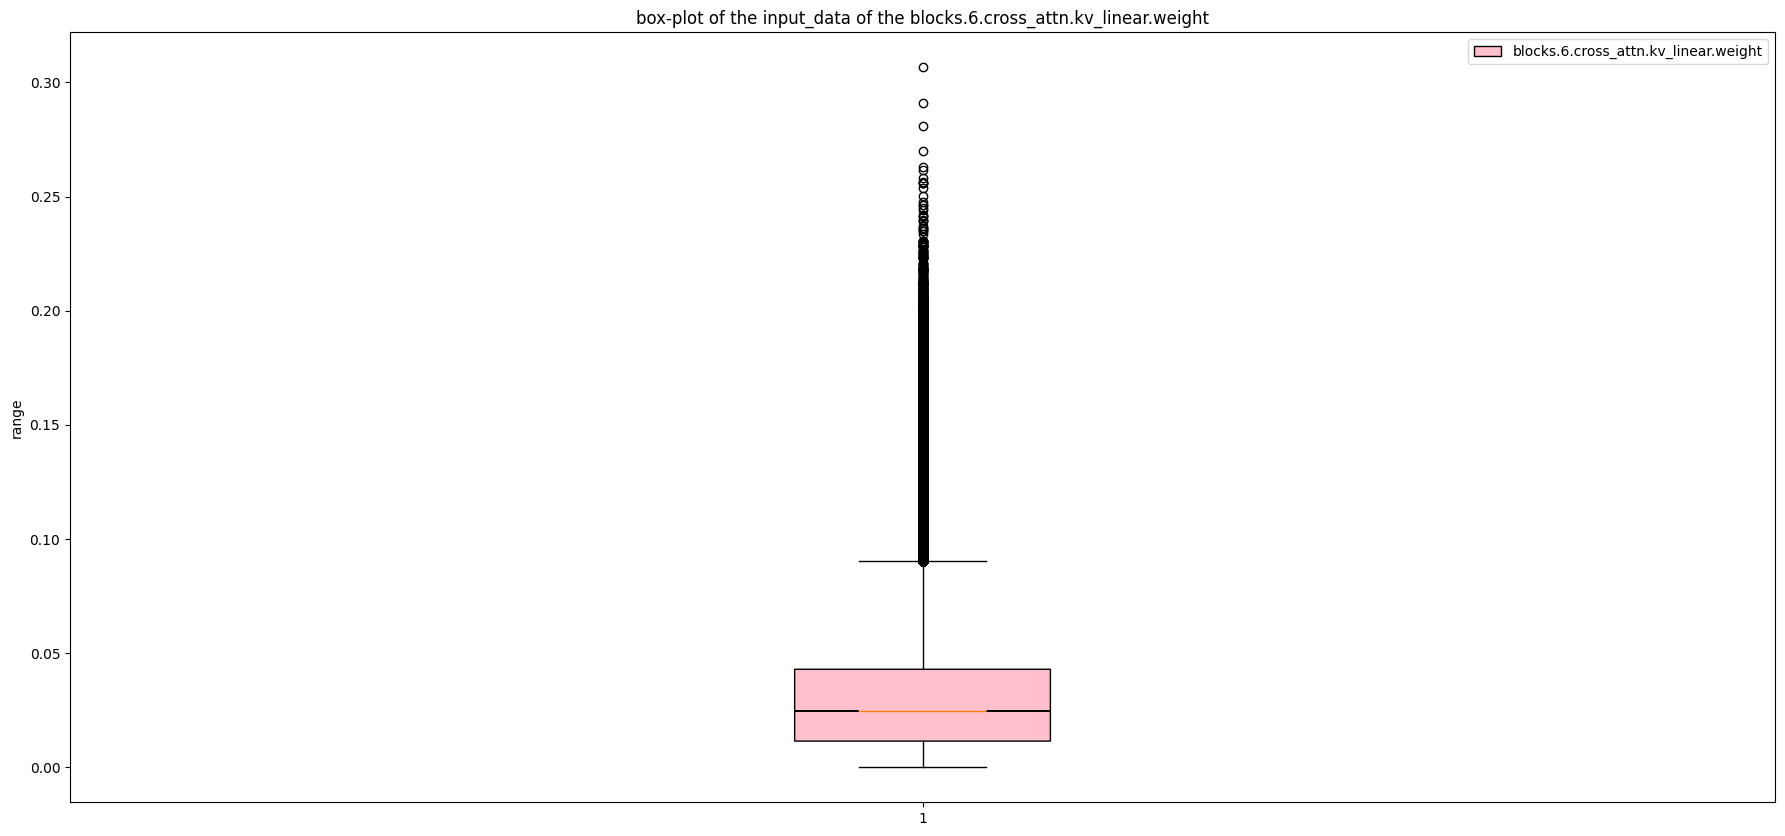

In [46]:
# Box plot
# Distribution plot

# part_weights = select_random_indices(weights, l=10, select_dim=2)
part_weights = weights
plot_activation_box(part_weights, name=name)

torch.Size([50, 1152])


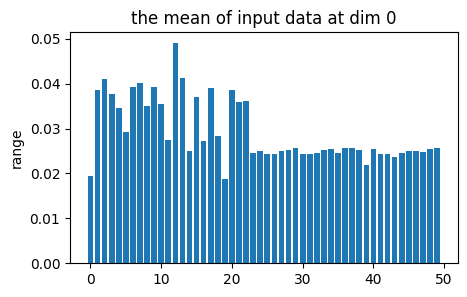

In [49]:
# Difference between different channels
# the following process should differ with different input data

part_weights = select_random_indices(weights, l=50, select_dim=0)
plot_activation_channel(part_weights, split_dim=0, name=name)